# Parte 1: Cuestionario (2.5 puntos)

### 1.1 *(0.5 puntos)* Explicar por qué es preferible hacer np.dot(X, Y), donde X e Y son arrays bidimensionales, que ejecutar un triple bucle con el algoritmo básico de la multiplicación de matrices.

Las computadoras modernas llevan instrucciones SIMD . Este tipo de operaciones hacen que las operaciones vectoriales como np.dot se realicen de manera eficiente y por tanto sean preferibles que las operaciones elemento a elemento como en el caso del uso del triple bucle. 

Esto se debe principalmente por los siguientes motivos:


* Los procesadores tienen registros (por ejemplo, de 256 bits) donde almacenar múltiples elementos.

* Con una sola instrucción, un procesador puede efectuar una suma de varios elementos a la vez, en vez de tener que ir sumando elemento a elemento (una especie de _data parallelism_ consistente en que un único núcleo pueda ejecutar una instrucción a varios elementos).

* Esto aumenta drásticamente la velocidad de operaciones como suma o producto de vectores y matrices.

* Numpy usa internamente las librerias BLAS, ATLAS específicas del algebra lineal: 
https://en.wikipedia.org/wiki/Automatically_Tuned_Linear_Algebra_Software





### 1.2 *(0.5 puntos)* Explicar qué ventajas nos aporta utilizar un grafo de computación a la hora de entrenar redes neuronales.

El uso de los grafos de computación dan una serie de ventajas que facilitan el entrenamiento de las redes neuronales

* **Validación y optimización de los cálculos a realizar**. Más velocidad de ejecución: Esto quiere decir que si el sistema conoce previamente las operaciones a realizar, éste podrá optimizar el proceso para que sea más eficiente


* **Facilita la auto-diferenciación**: gracias a esto TF es capaz de calcuar las derivadas nodo a nodo

* **Facilita la ejecución en entornos distribuidos y GPUs**:  el grafo se puede dividir en tareas más sencillas permitiendo que distintas partes del sistema se encargen de cada tarea


### 1.3 *(0.5 puntos)* Hemos visto cómo con TensorFlow es posible añadir una operación de optimización (como *tf.train.GradientDescentOptimizer*) y aplicar con ésta la minimización de la función de pérdida. Explicar cómo afecta esto al grafo de computación y cuál es su relación con el entrenamiento de una red neuronal.

Un optimizador se aplica a los gradientes calculados de las variables del modelo con el objetivo de minimizar el _loss_. 

Estos gradientes tienen impactos en las distintas capas de la red ya que actualizan los pesos de los _caminos_ entre unidades (neuronas) y los _bias_ con el obejtivo de reducir el _loss_ y por ende lograr mejores predicciones.

En la siguiente imagen se observa como esto afecta al grado de computación

![Gráfico de computación](https://www.tensorflow.org/images/mnist_deep.png)

https://www.tensorflow.org/guide/graphs

Como observamos en el grafico previo, en este caso un optimizador Adam, tiene impacto en cada capa e interviene en el cálculo del gradiente.

Si nos fijamos en el recuadro rojo de la siguiente imagen, podemos ver como actúa el optimizador en el cálculo del gradiente.
![cálculo del gradiente](https://i.stack.imgur.com/nFc5Y.png)




### 1.4 *(0.5 puntos)* ¿Qué diferencias hay entre grafos estáticos y grafos dinámicos?




Un gráfico estático se crea y después se ejecuta (_define-and-run_), en cambio un gráfico dinámico se va calculando según el código se va ejecutando (_define-by-run_).
Los grafos dinámicos permiten ejecutar código de una manera más imperativa, las operaciones se ejecutan al instante al contrario que en los gráficos estáticos que tenemos que definir el grafo y luego ejecutarlo dentro de una sesión. Además los dinámicos permiten ejecutar instrucciones línea a línea. Otra de las ventajas que tiene los gráficos dinámicos es que permiten construir grafos diferentes para distintos inputs, como estructuras _if/else_. 

Los gráficos dinámicos son útiles cuando estamos experimentando y probando, en cambio los estáticos son más utiles en producción y para entrenamiento distribuido ya que mejoran el rendimiento y tienen mayor facilidades en entornos reales




pag: 55, 88-97

### 1.5 *(0.5 puntos)* Algunas ops en redes neuronales tienen un comportamiento diferente durante *training time* (cuando entrenamos la red) que durante *inference time* (cuando utilizamos la red ya entrenada). Da un ejemplo de una operación usada en redes neuronales de este tipo y explicar la diferencia en ejecución. ¿Qué consecuencias tiene esto en relación al grafo de computación?

Un operación muy utilizada y significativa en el entrenamiento de redes neuronales es el drop-out que consisite en "apagar" una serie de neuronas para que la propagación no pasen por ellas. El objetivo del drop-out es evitar _overfiting_ del modelo.

![drop-out](https://cdn-images-1.medium.com/max/800/1*iWQzxhVlvadk6VAJjsgXgg.png)

Esto sólo tiene sentido en el entrenamiento de la red, ya que, el objetivo es que los pesos que intervienen en esas neuronas no se actualicen en esa etapa.  En la fase de inferencia, el drop-out debe ser "evitado" ya que todas las neuronas deben estar activas con sus pesos calculados en el entrenamiento.

Todo esto afecta en el grafo de computación ya que en el entrenamiento incluirá una tarea de drop-out entre las capas que corresponda y en inferencia no.

Como podemos ver, en el código adjunto de la página de TensorFlow,  si en el modelo creado se pone "training=False" realmente estamos desactivando el drop-out cuando no entrenamos.

https://www.tensorflow.org/api_docs/python/tf/keras/models/Model

import tensorflow as tf

class MyModel(tf.keras.Model):

  def __init__(self):
  
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
    self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, inputs, t**raining=False**):
  
    x = self.dense1(inputs)
    if training:
      x = self.dropout(x, training=training)
    return self.dense2(x)


Otro tema que afecta de distinta forma es el _batch size_, en entrenamiento son los disitntos bloques que pasamos a la red para que ésta vaya aprendiendo condicionando la actualización de pesos y la velocidad de aprendizaje.

En la fase de inferencia el _batch size_ sólo interviene en cuantas predicciones hará por bloque, pero el resultado no debería variar. 

Para complementar se puede ver el caso de _.evaluate_:
* Por ejemplo si _batch size_ es 32 significa que dividirá la muestra de test en bloques de 32, a cada bloque aplicará la red y obtendrá unas medidas de performance
* Entiendo que luego hará una media de las medidas de performance  para obtener una performance media. Este valor medio, como (casi) todos los bloques tienen el mismo tamaño, variará muy poco con respecto al tamaño del _batch size_

Esto tiene un impacto claro en el grafo de computación ya que en el caso de entrenamiento aplicará a cada época y en el caso de inferencia sólo subdividirá la muestra

Otra operación que afecta de manera distinta es el _batch normalization_. En entrenamiento tendrá que calcular la media y la desviación típica para realizar el escalado. En la fase de test estos hiperparámetros ya están calculados y se usan directamente sobre los valores salida de las capas. En el grafo de entrenamiento habrá un proceso en las capas afectadas, en el grafo de test este proceso desaparece ya que no hay cálculo de la media y la desviación típica porque éstas se dan como parámetros.

https://www.quora.com/How-does-batch-normalization-behave-differently-at-training-time-and-test-time


Otras operaciones que cambian son por ejemplo  las regularizaciones L1 y L2, ya que sólo intervienen en la actualización de pesos en el entrenamiento.



# Parte 2: Laboratorio (7.5 puntos)

---



En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el clásico dataset de MNIST. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [0]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob

Using TensorFlow backend.


In [0]:


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10665984/10658925 [==============================] - 5s 0us/step


In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [0]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)


In [0]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [0]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [0]:
###desordenar 

arr= np.arange(len(X))
np.random.shuffle(arr)

In [0]:
arr

array([ 7814,  7127,  8138, ...,  9311, 10083, 14524])

In [0]:
X =X[arr]

y =y[arr]


In [0]:
np.shape(X), np.shape(y), np.shape(X_t), np.shape(y_t)

((18992, 64, 64, 3), (18992,), (890, 64, 64, 3), (890,))

In [0]:
y

array([ 7,  7,  7, ...,  9, 10, 13])

In [0]:
#escalado

X_scale = X/255
X_t_scale = X_t/255

In [0]:
#convertir en one-hot encoding
from keras.utils import to_categorical
y_cat = to_categorical(y)
y_t_cat = to_categorical(y_t)

In [0]:
y_t_cat[2], y_t[2]

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=float32), 5)

#1 Red Neuronal Clásica



In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input,MaxPooling2D, Conv2D, ZeroPadding2D, Flatten, GlobalAveragePooling2D
from keras.optimizers import RMSprop, Nadam
from keras.utils import np_utils
from keras import regularizers
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [0]:
### Convertimos los datos de imagen a una dimension que soporte el mlp

dimData = 64*64*3

X_scale_mlp = X_scale.reshape(X_scale.shape[0], dimData)
X_t_scale_mlp = X_t_scale.reshape(X_t_scale.shape[0], dimData)

In [0]:
np.shape(X_scale_mlp), np.shape(X_t_scale_mlp)

((18992, 12288), (890, 12288))

In [0]:
def create_modelo_mlp():
  
  l=0.01
  rate = 0.1
  x = Input(shape=(12288,))
  layer = Dense(100, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(x)
  layer = Dropout(rate)(layer)
  layer = BatchNormalization()(layer)
  layer = Dense(100, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
  layer = Dropout(rate)(layer)
  layer = BatchNormalization()(layer)
  layer = Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1(l))(layer)
  layer = Dropout(rate)(layer)
  layer = BatchNormalization()(layer)
  y = Dense(18, activation='softmax',kernel_initializer='he_uniform')(layer)
  mlp = Model(x, y)
  
  nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

#callback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)]
  mlp.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return mlp

In [0]:
mlp = create_modelo_mlp()

In [0]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 12288)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               1228900   
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 100)               400       
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 100)               400       
__________

In [0]:
start = time.time()
mlp_fit = mlp.fit(X_scale_mlp, y_cat,
                epochs=100,
                batch_size=64,
                shuffle=True,
#                callbacks = callback,
                 validation_split=0.2)
end = time.time()
timeRNN = end-start

Train on 15193 samples, validate on 3799 samples
Epoch 1/100
15193/15193 [==============================] - 8s 517us/step - loss: 33.5301 - acc: 0.1140 - val_loss: 19.1887 - val_acc: 0.1153
Epoch 2/100
15193/15193 [==============================] - 6s 368us/step - loss: 15.9840 - acc: 0.1418 - val_loss: 15.5749 - val_acc: 0.0745
Epoch 3/100
15193/15193 [==============================] - 6s 363us/step - loss: 15.2889 - acc: 0.1586 - val_loss: 18.9072 - val_acc: 0.1042
Epoch 4/100
15193/15193 [==============================] - 5s 356us/step - loss: 14.4855 - acc: 0.1525 - val_loss: 12.0123 - val_acc: 0.1250
Epoch 5/100
15193/15193 [==============================] - 5s 353us/step - loss: 13.8393 - acc: 0.1561 - val_loss: 15.6488 - val_acc: 0.0803
Epoch 6/100
15193/15193 [==============================] - 5s 358us/step - loss: 13.6121 - acc: 0.1597 - val_loss: 14.6845 - val_acc: 0.0777
Epoch 7/100
15193/15193 [==============================] - 5s 356us/step - loss: 13.3777 - acc: 0.1640 - 

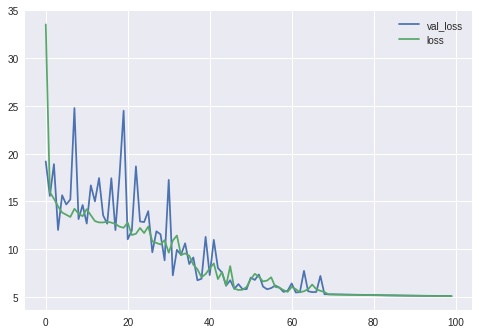

In [0]:
plt.plot(mlp_fit.history['val_loss'], label='val_loss')
plt.plot(mlp_fit.history['loss'], label='loss')
plt.legend()
plt.show()

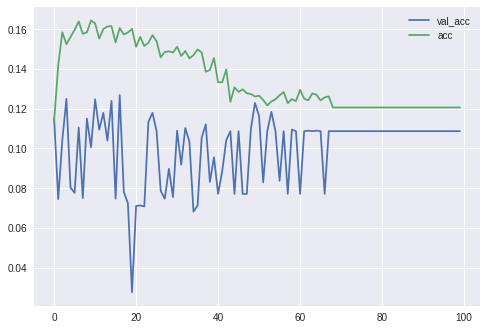

In [0]:
plt.plot(mlp_fit.history['val_acc'], label='val_acc')
plt.plot(mlp_fit.history['acc'], label='acc')
plt.legend()
plt.show()

In [0]:
mlp.evaluate(X_t_scale_mlp, y_t_cat)

890/890 [==============================] - 0s 138us/step


[5.2938466018505315, 0.05617977532275607]

En general este tipo de red no funciona con imagenes complejas, necesitaría muchas mas capas y unidades para tener un buen resultado

#2 CNN

In [0]:
import tensorflow as tf

In [0]:
from keras import backend as K
print(K.image_data_format()) # print c

channels_last


In [0]:
def create_modelo_CNN():
  


  model = Sequential()
  model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(64,64,3)))
  model.add(Conv2D(32, kernel_size=3, activation='relu'))
  model.add(GlobalAveragePooling2D())
  #model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(18, activation='softmax'))


  model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
CNN = create_modelo_CNN()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 32)        18464     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               16896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
__________

In [0]:
start = time.time()
CNN_fit = CNN.fit(X_scale, y_cat,
                epochs=200,
                batch_size=64,
                shuffle=True,
#                callbacks = callback,
                 validation_split=0.2)
end = time.time()
timeRNN = end-start

Train on 15193 samples, validate on 3799 samples
Epoch 1/200
15193/15193 [==============================] - 11s 710us/step - loss: 2.7524 - acc: 0.1283 - val_loss: 2.5660 - val_acc: 0.1832
Epoch 2/200
15193/15193 [==============================] - 10s 663us/step - loss: 2.5008 - acc: 0.2100 - val_loss: 2.3744 - val_acc: 0.2440
Epoch 3/200
15193/15193 [==============================] - 10s 663us/step - loss: 2.3134 - acc: 0.2730 - val_loss: 2.2174 - val_acc: 0.3024
Epoch 4/200
15193/15193 [==============================] - 10s 660us/step - loss: 2.1810 - acc: 0.3124 - val_loss: 2.0339 - val_acc: 0.3525
Epoch 5/200
15193/15193 [==============================] - 10s 665us/step - loss: 2.0661 - acc: 0.3486 - val_loss: 2.1622 - val_acc: 0.3127
Epoch 6/200
15193/15193 [==============================] - 10s 663us/step - loss: 1.9603 - acc: 0.3803 - val_loss: 1.8619 - val_acc: 0.3996
Epoch 7/200
15193/15193 [==============================] - 10s 663us/step - loss: 1.8561 - acc: 0.4112 - val_lo

In [0]:
timeRNN/60

33.5034038066864

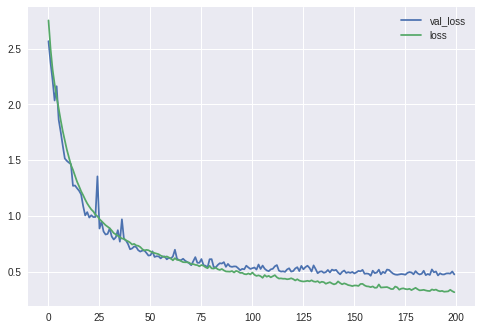

In [0]:
plt.plot(CNN_fit.history['val_loss'], label='val_loss')
plt.plot(CNN_fit.history['loss'], label='loss')
plt.legend()
plt.show()

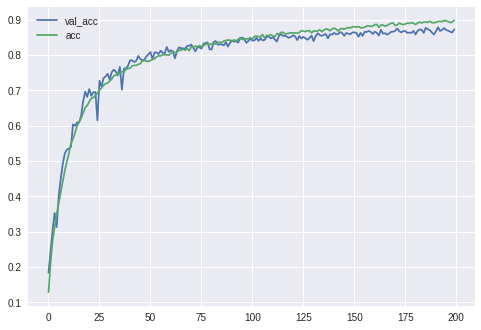

In [0]:
plt.plot(CNN_fit.history['val_acc'], label='val_acc')
plt.plot(CNN_fit.history['acc'], label='acc')
plt.legend()
plt.show()

In [0]:
CNN.evaluate(X_t_scale, y_t_cat)

890/890 [==============================] - 0s 417us/step


[0.24334122150131826, 0.9314606733536452]

93,1% de Accuracy en test.

He probado varias CNN, algunas con módulos de VGGNet, pero el problema que tienen esas redes es que necesitas muchos datos para entrenarlas (y tiempo...).

Una opción hubiera sido usar transfer learning con un "fine tunning", pero como los resultados son buenos no ha sido necesario.


"Cuando dos o más explicaciones se ofrecen para un fenómeno, la explicación completa más simple es preferible; es decir, no deben multiplicarse las entidades sin necesidad." (Navaja de Ockham)

#3 GPU vs CPU

### GPU:

Epoch 1/200
15193/15193 [==============================] - 11s 710us/step - loss: 2.7524 - acc: 0.1283 - val_loss: 2.5660 - val_acc: 0.1832

Epoch 2/200
15193/15193 [==============================] - 10s 663us/step - loss: 2.5008 - acc: 0.2100 - val_loss: 2.3744 - val_acc: 0.2440

### CPU:

Epoch 1/200
15193/15193 [==============================] - 330s 22ms/step - loss: 2.8096 - acc: 0.1065 - val_loss: 2.7629 - val_acc: 0.1277

Epoch 2/200
15193/15193 [==============================] - 330s 22ms/step - loss: 2.7996 - acc: 0.1179 - val_loss: 2.8070 - val_acc: 0.1137





El uso de la GPU hace que el proceso sea mucho más rápido ya que una GPU tiene muchos más núcleos que una CPU y por tanto se pueden paralelizar mucho más los proceso.

En concreto Colaboratory nos deja una Tesla K-80 que tiene casi 5000 cores CUDA, es decir que se puede paralelizar casi 5000 procedimientos.

La frecuencia de reloj de una GPU es inferior a la de la CPU pero el hecho que la primera tenga casi 1000 veces más núcleos hace que la GPU tenga una performance superior en operaciones paralelizables

A continuación se muestra un gráfico con las mejoras:

![texto alternativo](https://www.nvidia.com/content/dam/en-zz/es_em/Solutions/Data-Center/tesla-k80/data-center-nvidia-tesla-k80-performance-843-ud.jpg)

https://www.nvidia.com/en-gb/data-center/tesla-k80/


# 6 Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [0]:
CNN_2 = create_modelo_CNN()

In [0]:
BS = 50
start = time.time()

CNN_2_fit=CNN_2.fit_generator(datagen.flow(X, y_cat, batch_size=BS),
                    epochs=50,
                    steps_per_epoch=len(X) / BS,
                    shuffle=True)

end = time.time()
timeRNN = end-start

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


380/379 [==============================] - 30s 80ms/step - loss: 2.6734 - acc: 0.1537
Epoch 2/50
380/379 [==============================] - 30s 79ms/step - loss: 2.3654 - acc: 0.2603
Epoch 3/50
380/379 [==============================] - 30s 79ms/step - loss: 2.1996 - acc: 0.3067
Epoch 4/50
380/379 [==============================] - 30s 79ms/step - loss: 2.0463 - acc: 0.3543
Epoch 5/50
380/379 [==============================] - 30s 79ms/step - loss: 1.8921 - acc: 0.4088
Epoch 6/50
380/379 [==============================] - 30s 80ms/step - loss: 1.7419 - acc: 0.4553
Epoch 7/50
380/379 [==============================] - 30s 79ms/step - loss: 1.6483 - acc: 0.4861
Epoch 8/50
380/379 [==============================] - 30s 80ms/step - loss: 1.5611 - acc: 0.5167
Epoch 9/50
380/379 [==============================] - 30s 80ms/step - loss: 1.4824 - acc: 0.5413
Epoch 10/50
380/379 [==============================] - 30s 79ms/step - loss: 1.4302 - acc: 0.5585
Epoch 11/50
380/379 [===================

In [0]:
timeRNN/60

25.22111568450928

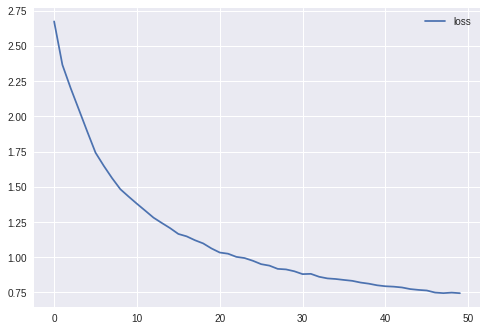

In [0]:
plt.plot(CNN_2_fit.history['loss'], label='loss')
plt.legend()
plt.show()

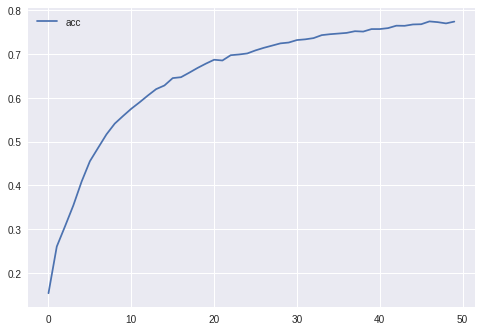

In [0]:
plt.plot(CNN_2_fit.history['acc'], label='acc')
plt.legend()
plt.show()

In [0]:
CNN_2.evaluate(X_t_scale, y_t_cat)

890/890 [==============================] - 0s 559us/step


[0.530647392219372, 0.8325842699308074]

En este caso hemos entrenado sólo 50 épocas y ha tardado 25 minutos frente al modelo sin data augmentation que se ha entrenado 200 épocas y ha tardado 33 minutos obteniendo mejores resultados. Luego en este caso podemos usar los datos sin data augmentation, ya que, aproximadamente ámbos modelos tiene el mismo resultado en la época 50.

Yo creo el hecho de que el data augmentantion no mejore el modelo se debe principalmente a que los personajes se encuentran en disitintas posturas en las fotos y por ello la muestra de entrenamiento es buena para entrenar el modelo.

## 4

### Así se haría la ingesta y el data augmentation con tf.data

#### Me dió problemas con la Memoria de la GPU, por ello lo dejo aquí a título ilustrativo

#### Los datos se pueden pasar ya escalados o escalar directamente haciendo:

dataset_train = tf.data.Dataset.from_tensor_slices( (tf.cast(X[...,tf.newaxis]/255, tf.float32),  tf.cast(y_cat,tf.int64)))

dataset_test = tf.data.Dataset.from_tensor_slices( (tf.cast(X_t[...,tf.newaxis]/255, tf.float32),  tf.cast(y_t_cat,tf.int64)))

En este caso los tenemos que pasar separados "X" e "y" para poder aplicar las transformaciones de data augmentantion en "X"

In [0]:
dataset_train_X = tf.data.Dataset.from_tensor_slices(X_scale)

dataset_train_y = tf.data.Dataset.from_tensor_slices(y_cat)



In [0]:
dataset_train_X_t = tf.data.Dataset.from_tensor_slices(X_t_scale)

dataset_train_y_t = tf.data.Dataset.from_tensor_slices(y_t_cat)

In [0]:
# dataset_train = tf.data.Dataset.from_tensor_slices(
#   (X_scale,y_cat))
# dataset_train = dataset_train.shuffle(1000).batch(32)
# 
# dataset_test = tf.data.Dataset.from_tensor_slices(
#    (X_t_scale,y_t_cat))
# dataset_test = dataset_test.shuffle(1000).batch(32)

#### Data Augmentation
Extraido de: https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

In [0]:
# https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/
def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1

    plt.figure()
    plt.imshow(output)
    plt.show()

def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random_uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))


In [0]:


# dataset_train_X_aug = dataset_train_X.map(lambda x: flip(x))
# dataset_train_X_aug = dataset_train_X_aug.map(lambda x: color(x))
# dataset_train_X_aug = dataset_train_X_aug.map(lambda x: rotate(x))
# dataset_train_X_aug = dataset_train_X_aug.map(lambda x: zoom(x))


In [0]:
augmentations = [flip, color, rotate]
for f in augmentations:
    dataset_train_X = dataset_train_X.map(lambda x: tf.cond(tf.random_uniform([], 0, 1) > 0.75, lambda: f(x), lambda: x))
dataset_train_X = dataset_train_X.map(lambda x: tf.clip_by_value(x, 0, 1))

## Entregable

Utilizando Convolutional Neural Networks con TensorFlow (ya sea tf.keras, TensorFlow Eager, o TensorFlow tradicional), entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **88%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

El entregable (en formato .ipynb, aunque puede apoyarse con un archivo pdf) tiene que contener los siguientes elementos:

**1 (1.5 puntos): Implementación con una red neuronal clásica**. Implementar primero un modelo feed-forward clásico, sin convoluciones. Mostrar código y  resultados de entrenamiento y accuracy en el test set.

**2 (4.5 puntos): Implementación con CNNs**. Implementar una arquitectura CNN que consiga un 88% de accuracy en el test set. Mostrar código y resultados de entrenamiento y accuracy en el test set. Explicar brevemente la arquitectura utilizada y las pruebas realizadas.

**3 (1 punto): Comparación GPU/CPU**. Comparar el tiempo de entrenamiento de tu modelo por epoch utilizando GPUs y CPUs. Explicar por qué el uso de una aceleradora como una GPU acelera el entrenamiento de la red neuronal.

**4 (0.5 puntos): Utilización de tf.data**. Si no se ha entrenado el modelo en el paso 2 con tf.data, repetir la ingesta de datos (incluyendo el preprocesamiento de imágenes) para el modelo utilizando tf.data.

**5 [optativo] (1 punto extra). Implementar el modelo en TensorFlow Eager o TF de bajo nivel, sin usar tf.keras.** El bucle de entrenamiento batch a batch también tiene que hacerse utilizando operaciones de bajo nivel. En resumen, no vale utilizar capas de Keras como convoluciones o Dense ni funciones como .fit(), hay que implementarlas. Podéis programar el modelo sin embargo utilizando Keras subclassing (tf.keras.Model).

**6 [optativo] (0.5 puntos extra). Utilizar data augmentation.** Utilizar la técnica de data augmentation y comentar los resultados. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras o con tf.data.


Notas: 
* Recuerda que suele ser útil partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para su análisis. Sin embargo, recordar que **se debe mostrar el entrenamiento completo del modelo final obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas (píxeles de 0 a 255 tienen que ir a un número real entre 0 y 1).
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que lo que vemos en el validation set de nuestro modelo.
* No es necesario probar modelos tan grandes que tarden horas en entrenar. Es posible alcanzar la accuracy requerida con modelos que entrenan rápido en GPUs.
* Ojo: los datos devueltos por las funciones *load_train_set* y *load_test_set* están ordenados personaje a personaje.